# Step1

### Target

1. Get the setup right
2. Read MNIST dataset, set train test split and create Data Loader
3. Get the summary statistics for the data
4. Set initial transforms and apply transformation to the train and test set separately
5. Get the basic neural net architecture skeleton right. We will try and avoid changing the skeleton later
6. Set basic training and test loop

### Results

1. Parameters: 992,800
2. Best Training Accuracy: 99.88
3. Best Test Accuracy: 99.14

### Analysis

1. Very heavy model for such an easy problem. Lots of parameters. Have to reduce the number of parameters in the next step
2. Test accuracy is way below the target accuracy
3. Model is overfitting

# Import Libraries
Import the necessary packages

In [69]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

# Read Dataset and Create Train/Test Split

In [70]:
train = datasets.MNIST('./data', train=True, download=True)
test = datasets.MNIST('./data', train=False, download=True)

# Data Statistics and Visualization

Let us check some of the summary statistics for our data. It will help us to set initial transform. We can also visualize some sample images to get an idea of what transforms we can apply later.

In [71]:
# Function to get summary statistics
def get_summary_stats(sample_data, data_label="Sample Data"):
  """
  Function to get summary statistics from a given data

  Args
  ----
  sample_data: Tensor
  data_label: str

  Returns
  -------
  None
  """
  sample = sample_data.data
  sample = sample.numpy()
  # Normalizing data between 0 and 1
  sample = sample/255
  print(f'Summary Statistics for {data_label}')
  print(' - Numpy Shape:', sample.shape)
  print(' - Tensor Shape:', sample.size)
  print(' - min:', np.min(sample))
  print(' - max:', np.max(sample))
  print(' - mean:', np.mean(sample))
  print(' - std:', np.std(sample))
  print(' - var:', np.var(sample))


In [72]:
combined_data = torch.cat([train.data, test.data])
get_summary_stats(train.data, data_label="Training Dataset")
print("\n")
get_summary_stats(test.data, data_label="Test Dataset")
print("\n")
get_summary_stats(combined_data, data_label="Complete Dataset")

Summary Statistics for Training Dataset
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: 47040000
 - min: 0.0
 - max: 1.0
 - mean: 0.1306604762738429
 - std: 0.3081078038564622
 - var: 0.09493041879725218


Summary Statistics for Test Dataset
 - Numpy Shape: (10000, 28, 28)
 - Tensor Shape: 7840000
 - min: 0.0
 - max: 1.0
 - mean: 0.13251460584233699
 - std: 0.3104802479305348
 - var: 0.09639798435500636


Summary Statistics for Complete Dataset
 - Numpy Shape: (70000, 28, 28)
 - Tensor Shape: 54880000
 - min: 0.0
 - max: 1.0
 - mean: 0.13092535192648502
 - std: 0.3084485240270358
 - var: 0.0951404919744569


Text(0.5, 1.0, 'Countplot for classes in training set')

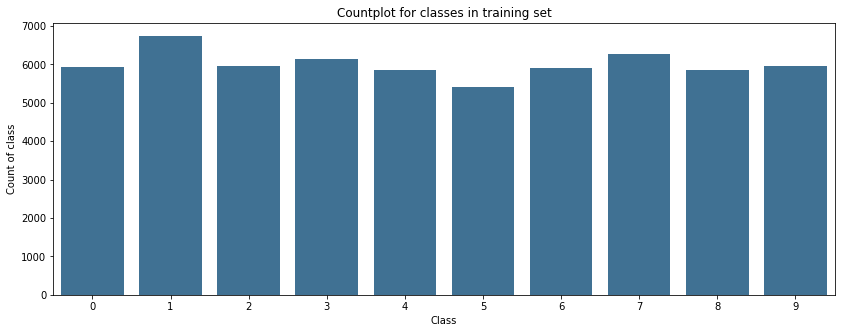

In [73]:
fig, ax = plt.subplots(figsize = (14, 5))
count_plot = sns.countplot(pd.Series(train.targets.numpy()), color="#3274a1", ax = ax)
ax.set_xlabel("Class")
ax.set_ylabel("Count of class")
ax.set_title("Countplot for classes in training set")

### Inference
The classes are almost balanced. No need for any class imbalance tricks

Now lets visualize some of the images

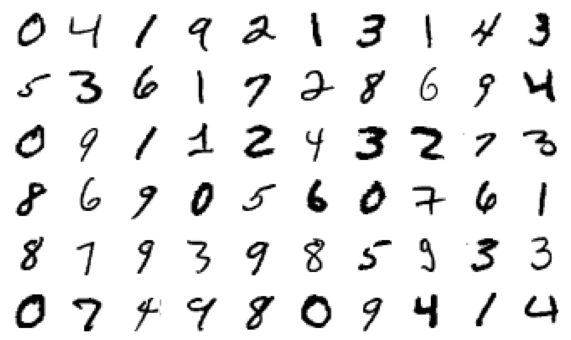

In [74]:
figure = plt.figure(figsize=(10, 6))
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(train.data.numpy()[index], cmap='gray_r')
#Deleting the combined data since its of no use any longer
del combined_data

# Setting Transforms
Now we can set transforms from the summary statistics. We will be applying the following transformations: 
* ToTensor() : It converts PIL image or numpy array to FloatTensor in the range of [0.0, 1.0]
* Normalize: It normalizes each channel of an input given a mean and std deviation. We have already ascertained the mean and std deviation of the dataset to be 0.1309 ad 0.3084

In [64]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),  
                                       transforms.Normalize((0.1309,), (0.3084,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1309,), (0.3084,))
                                       ])

In [75]:
#Read data and apply the above transforms
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Set Dataloader Arguments & Create Test/Train Dataloaders


In [77]:
# Set the manual seed
SEED = 1
# Initialize batch size
bs = 128
# Check for availability of cuda
cuda = torch.cuda.is_available()
print(" Is CUDA Available ?\n", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# Setting the dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=bs, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

 Is CUDA Available ?
 True


# The model architecture
Now we can setup or initial model skeleton

In [79]:
class Net(nn.Module):
    def __init__(self):
      """
      Initializes all the model layers
      """
      #Inheriting from the nn.Module class
      super(Net, self).__init__()
      
      #Convolution Block 1
      self.conv1 = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, bias=False, padding=0),
          nn.ReLU()
      ) #Input: 28X28X1 | Output: 26X26X32 | RF: 3

      #Convolution Block 2
      self.conv2 = nn.Sequential(
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, bias=False, padding=0),
          nn.ReLU()
      ) #Input: 26X26X32 | Output: 24X24X64 | RF: 5

      #Convolution Block 3
      self.conv3 = nn.Sequential(
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, bias=False, padding=0),
          nn.ReLU()
      ) #Input: 24X24X64 | Output: 22X22X128 | RF: 7

      #Transition Block 1
      self.pool1 = nn.MaxPool2d(2, 2) #Input: 22X28X128 | Output: 11X11X128 | RF: 8
      self.conv4 = nn.Sequential(
          nn.Conv2d(in_channels=128, out_channels=32, kernel_size=1, bias=False),
          nn.ReLU()
      ) #Input: 11X11X128 | Output: 11X11X32 | RF: 8

      #Convolution Block 5
      self.conv5 = nn.Sequential(
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, bias=False, padding=0),
          nn.ReLU()
      ) #Input: 11X11X32 | Output: 9X9X64 | RF: 12

      #Convolution Block 6
      self.conv6 = nn.Sequential(
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, bias=False, padding=0),
          nn.ReLU()
      ) #Input: 9X9X64 | Output: 7X7X128 | RF: 16

      #Output Block
      self.conv7 = nn.Sequential(
          nn.Conv2d(in_channels=128, out_channels=128, kernel_size=7, bias=False, padding=0),
          nn.ReLU()
      ) #Input: 7X7X128 | Output: 1X1X128 | RF: 28
      
      self.conv8 = nn.Sequential(
          nn.Conv2d(in_channels=128, out_channels=10, kernel_size=1, bias=False, padding=0),
      ) #Input: 1X1X128 | Output: 1X1X10 | RF: 28


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool1(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
We can now check the model summary and see the total number of parameters

In [80]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu") #Use cuda if available else use cpu
print(device)
model = Net().to(device) #Sending the model to cuda if available otherwise use cpu
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,432
              ReLU-4           [-1, 64, 24, 24]               0
            Conv2d-5          [-1, 128, 22, 22]          73,728
              ReLU-6          [-1, 128, 22, 22]               0
         MaxPool2d-7          [-1, 128, 11, 11]               0
            Conv2d-8           [-1, 32, 11, 11]           4,096
              ReLU-9           [-1, 32, 11, 11]               0
           Conv2d-10             [-1, 64, 9, 9]          18,432
             ReLU-11             [-1, 64, 9, 9]               0
           Conv2d-12            [-1, 128, 7, 7]          73,728
             ReLU-13            [-1, 128, 7, 7]               0
           Conv2d-14            [-

# Training and Testing

All right, so we have 9.9M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cool looking logs. 

Let's write train and test functions

In [84]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    train_acc.append(100*correct/processed)
    pbar.set_description(desc=f'Loss={loss.item():0.4f} Batch_ID={batch_idx} Accuracy={train_acc[-1]:.2f}')

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_acc.append(100. * correct / len(test_loader.dataset))
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({test_acc[-1]:.2f}%)\n')

# Let's Train and test our model

In [85]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1078, Accuracy: 9648/10000 (96.48%)

EPOCH: 2


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0580, Accuracy: 9805/10000 (98.05%)

EPOCH: 3


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0455, Accuracy: 9863/10000 (98.63%)

EPOCH: 4


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 9869/10000 (98.69%)

EPOCH: 5


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9885/10000 (98.85%)

EPOCH: 6


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Accuracy: 9877/10000 (98.77%)

EPOCH: 7


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0395, Accuracy: 9889/10000 (98.89%)

EPOCH: 8


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0367, Accuracy: 9903/10000 (99.03%)

EPOCH: 9


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Accuracy: 9865/10000 (98.65%)

EPOCH: 10


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9904/10000 (99.04%)

EPOCH: 11


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0410, Accuracy: 9895/10000 (98.95%)

EPOCH: 12


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9895/10000 (98.95%)

EPOCH: 13


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0553, Accuracy: 9867/10000 (98.67%)

EPOCH: 14


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 9898/10000 (98.98%)

EPOCH: 15


Loss=0.0002 Batch_ID=468 Accuracy=99.88: 100%|██████████| 469/469 [00:21<00:00, 22.27it/s]



Test set: Average loss: 0.0388, Accuracy: 9914/10000 (99.14%)



Text(0.5, 1.0, 'Test Accuracy')

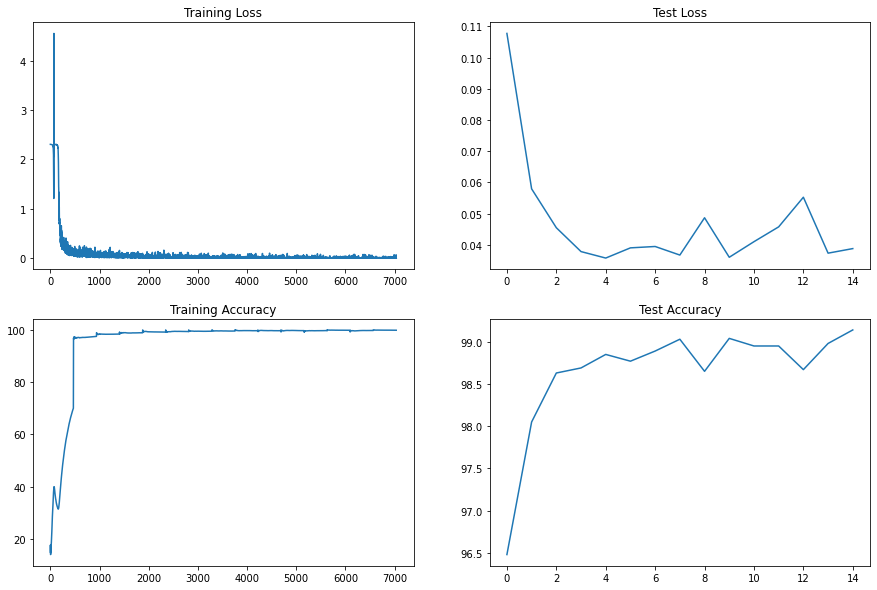

In [86]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")